In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20

def plot_img_label(img, lbl, cls_dict, n_classes=4, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

In [2]:
# set the number of object classes
n_classes = 4

In [3]:
# generate synthetic samples of 2D images, label masks, and class dicts 

def generate_sample(n=256):
    from scipy.ndimage.morphology import distance_transform_edt
    from skimage.segmentation import watershed, relabel_sequential 
    from skimage.morphology import disk, binary_erosion, binary_closing
    from scipy import ndimage as ndi
    m = np.random.randint(10,30)
    center = tuple(np.random.randint(0,n,(2,m)))
    markers = np.zeros((n,n),np.uint16)
    markers[center] = np.random.permutation(np.arange(1,m+1))
    
    dist = distance_transform_edt(1-1*(markers>0)) + 4*ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=1)
    dist *= np.random.uniform(1,2)
    y = watershed(dist, markers, mask=np.exp(-.1*dist)>.1)
        
    y = relabel_sequential(np.max(np.stack([i*binary_closing(y==i,disk(3)) for i in np.unique(y[y>0])],axis=0),axis=0))[0]

    ind = np.arange(1,y.max()+1)
    np.random.shuffle(ind)
    c1, c2 = ind[:len(ind)//2], ind[len(ind)//2:]
    m1 = np.isin(y,c1)
    m2 = np.isin(y,c2)    
    
    x =  ndi.filters.gaussian_filter((y>0).astype(np.float32),2)
        
    noise1 = ndi.zoom(np.random.uniform(0,1,(n//4,n//4)), (4,4), order=3)
    noise2 = ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=3)
    x[m1] = .2*(1+np.sin(y[m1]))+noise1[m1]
    x[m2] = .2*(1+np.sin(y[m2]))+noise2[m2]
    x = ndi.filters.gaussian_filter(x,1)+2*ndi.filters.gaussian_filter(x,20)
    gain = 100 
    x = np.random.poisson((1+gain*x).astype(int))/gain
    x += .08*np.random.normal(0,1,x.shape)
    cls = dict((i,1 if i in c1 else 2) for i in range(1,m+1))
    return x, y, cls

Generate a synthetic training set of 100 random images, label masks, and class dictionaries.

In [4]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict

    

X=[]
Y=[]
C=[]
for path in tqdm(os.listdir('data/Traning/')):
    roi=io.imread(glob.glob('data/Traning/'+path+'/image/*.png')[0])
    #height, width, _ = roi.shape
    height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob('data/Traning/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X.append(roi)
    Y.append(one_image)
    C.append(my_dict)
    
    

X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\Intel i7\Desktop\Jahid Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\Intel i7\Desktop\Jahid Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\Intel i7\Desktop\Jahid Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:22<00:00,  1.92it/s]


In [5]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
print(n_channel)

3


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.10 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [C[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train],  [C[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 1265
- training:       1139
- validation:     126


Training data consists of pairs of input image and label instances.

(<AxesSubplot:title={'center':'image'}>,
 <AxesSubplot:title={'center':'label'}>,
 <AxesSubplot:title={'center':'classes'}>)

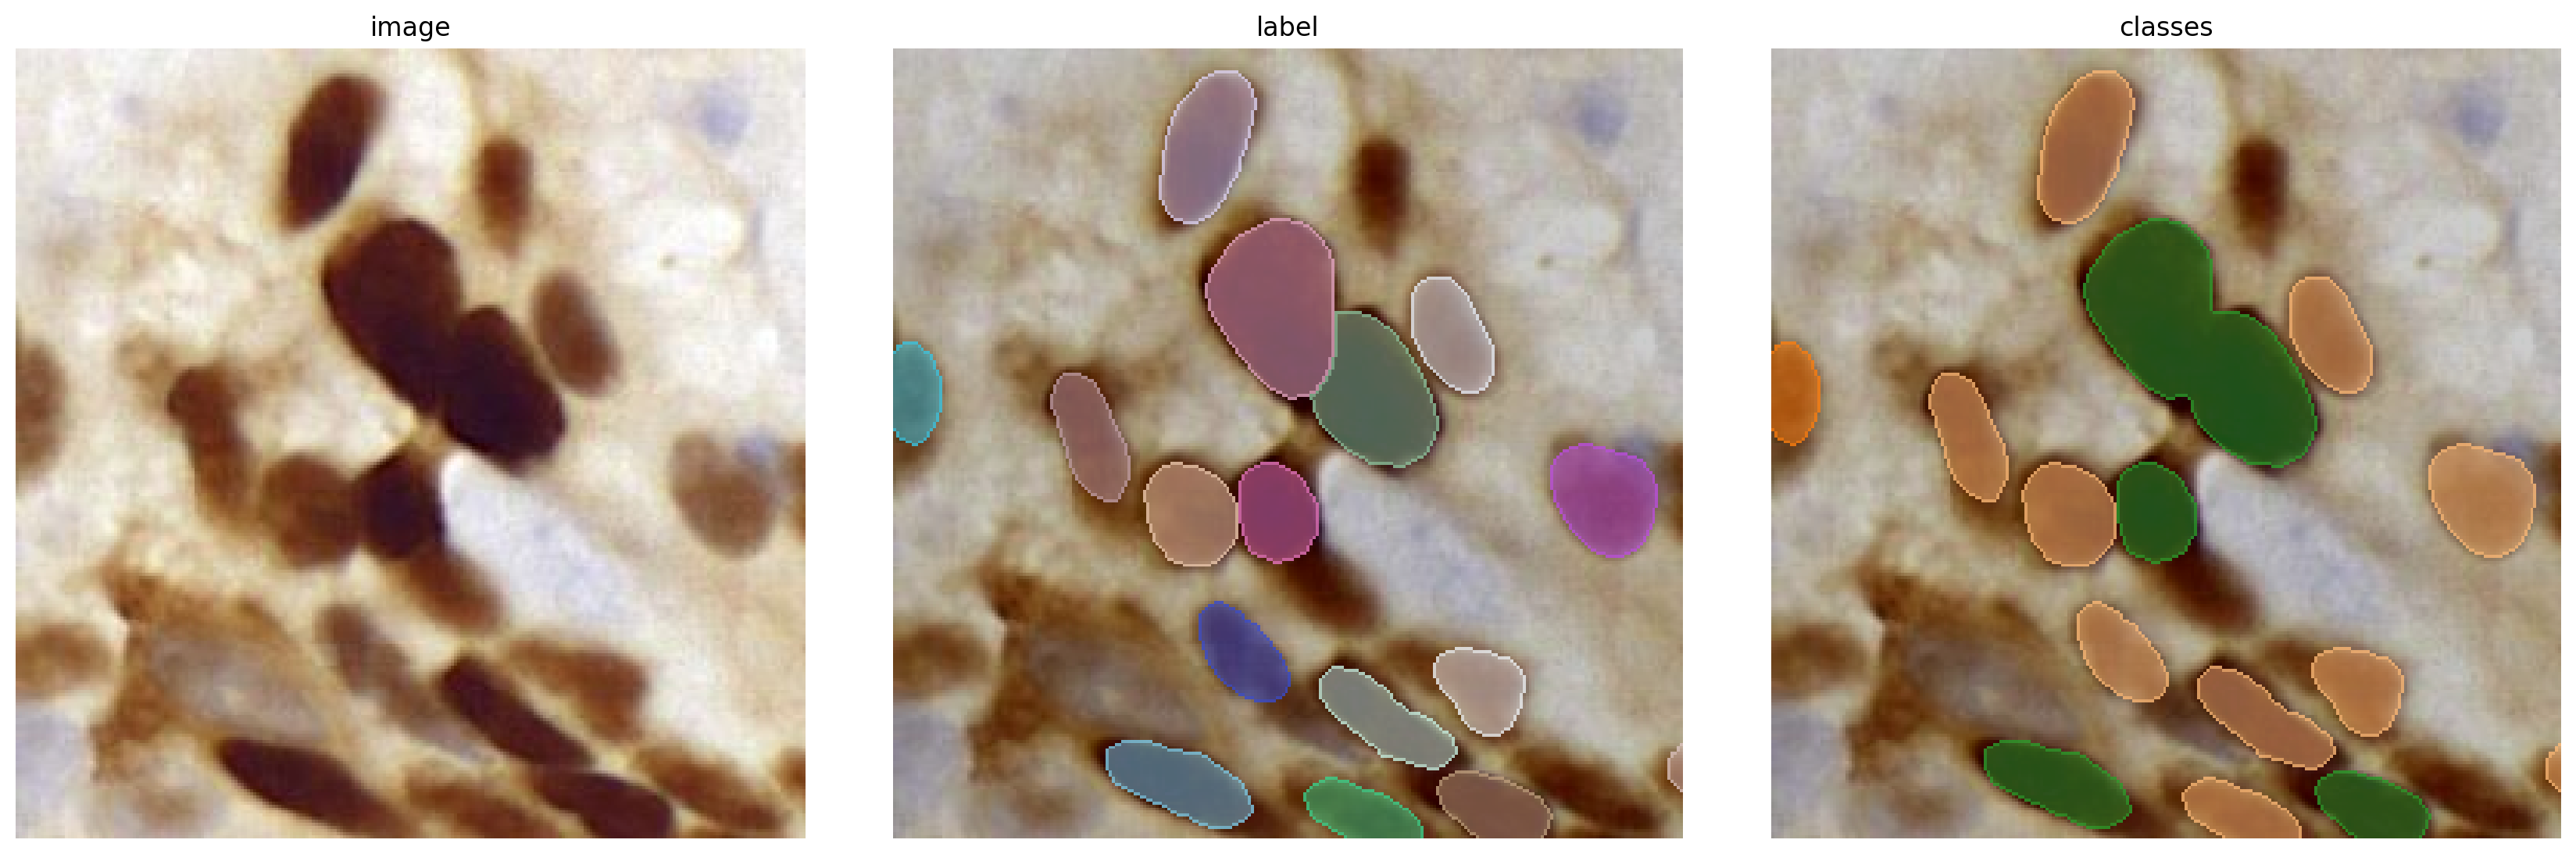

In [7]:
valuesss=95
plot_img_label(X_trn[valuesss],Y_trn[valuesss], C_trn[valuesss])

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

### Multi-class model

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In [9]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,
#     train_patch_size= (512, 512),
#     net_input_shape= (512, 512, 3),
#     net_mask_shape= (512, 512, 1)
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=4, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1, 1, 1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_del

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 4,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate':

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)    

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [11]:
model = StarDist2D(conf, name='unet_multiclass_ai4dp', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [12]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,1) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


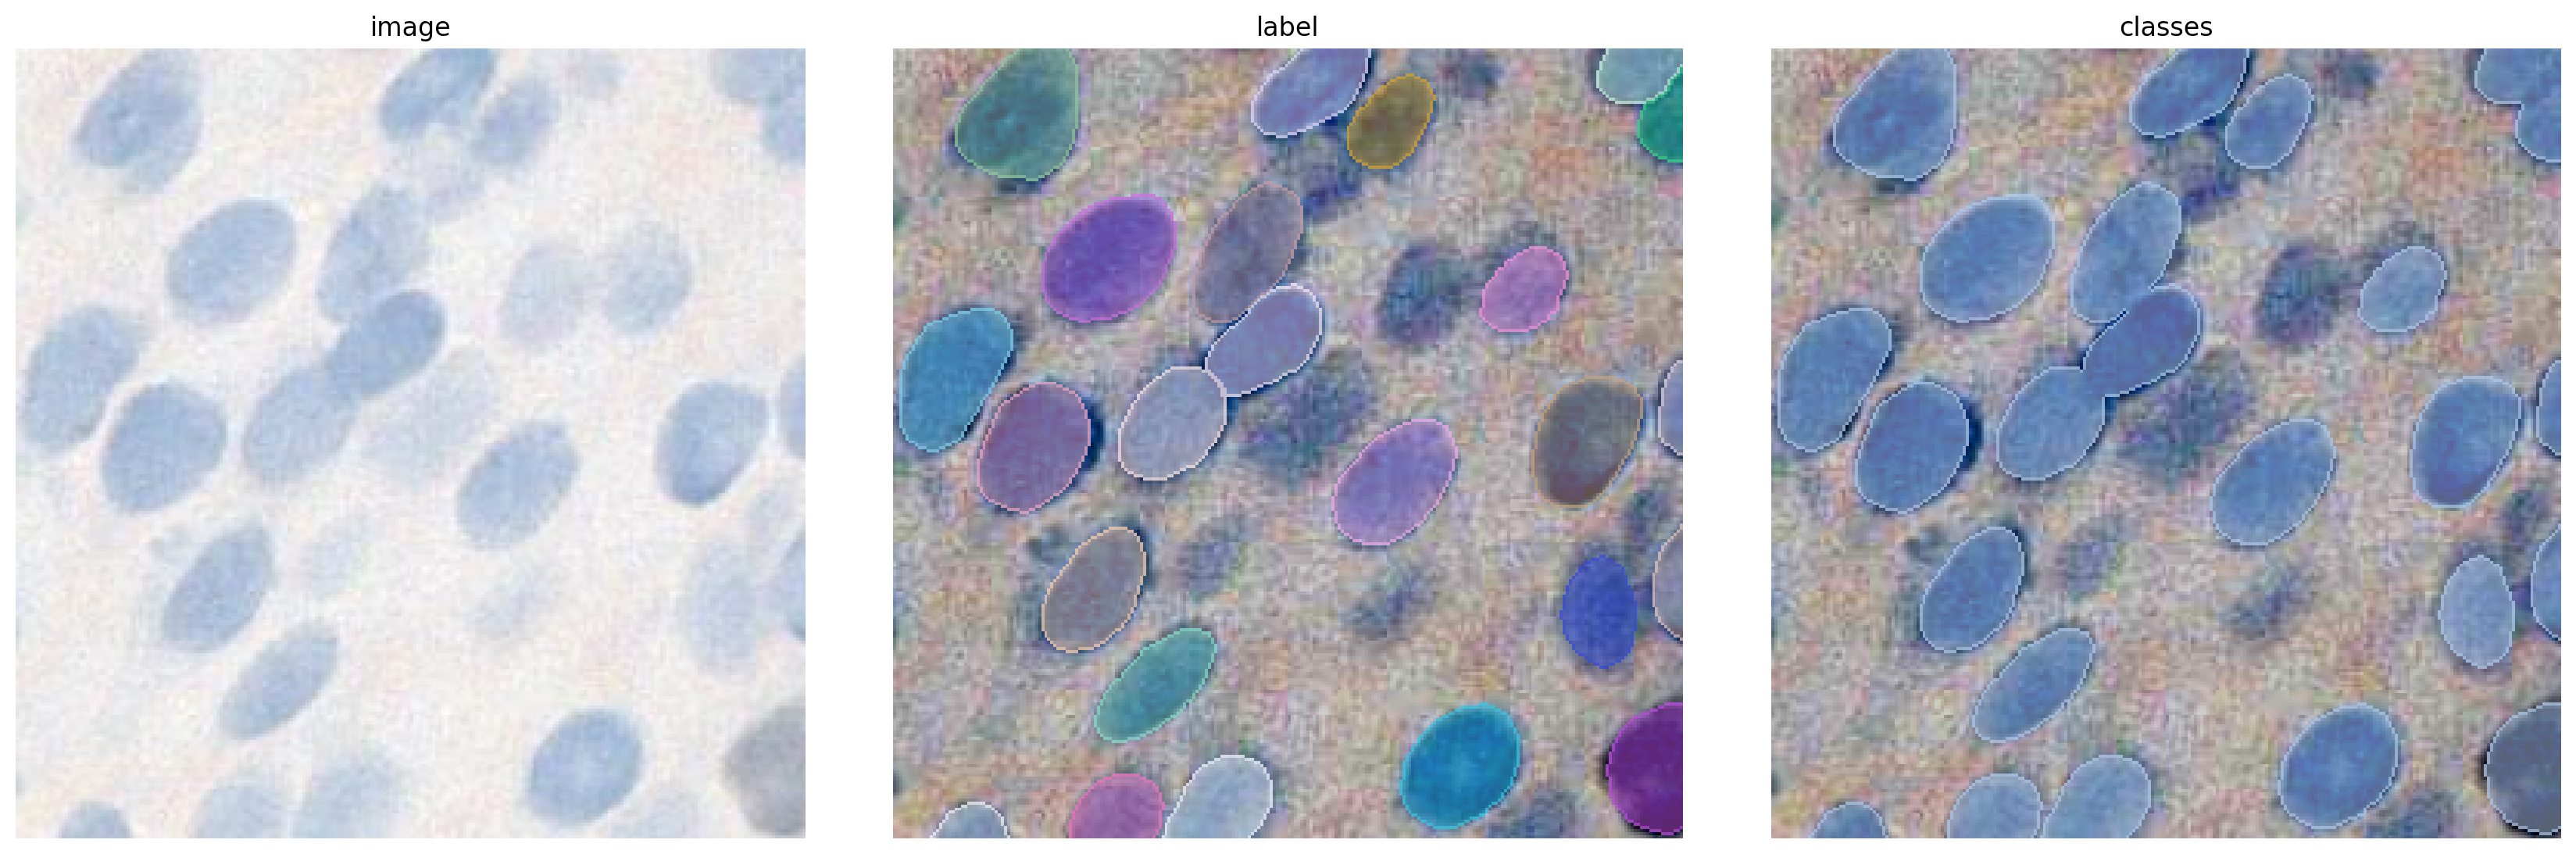

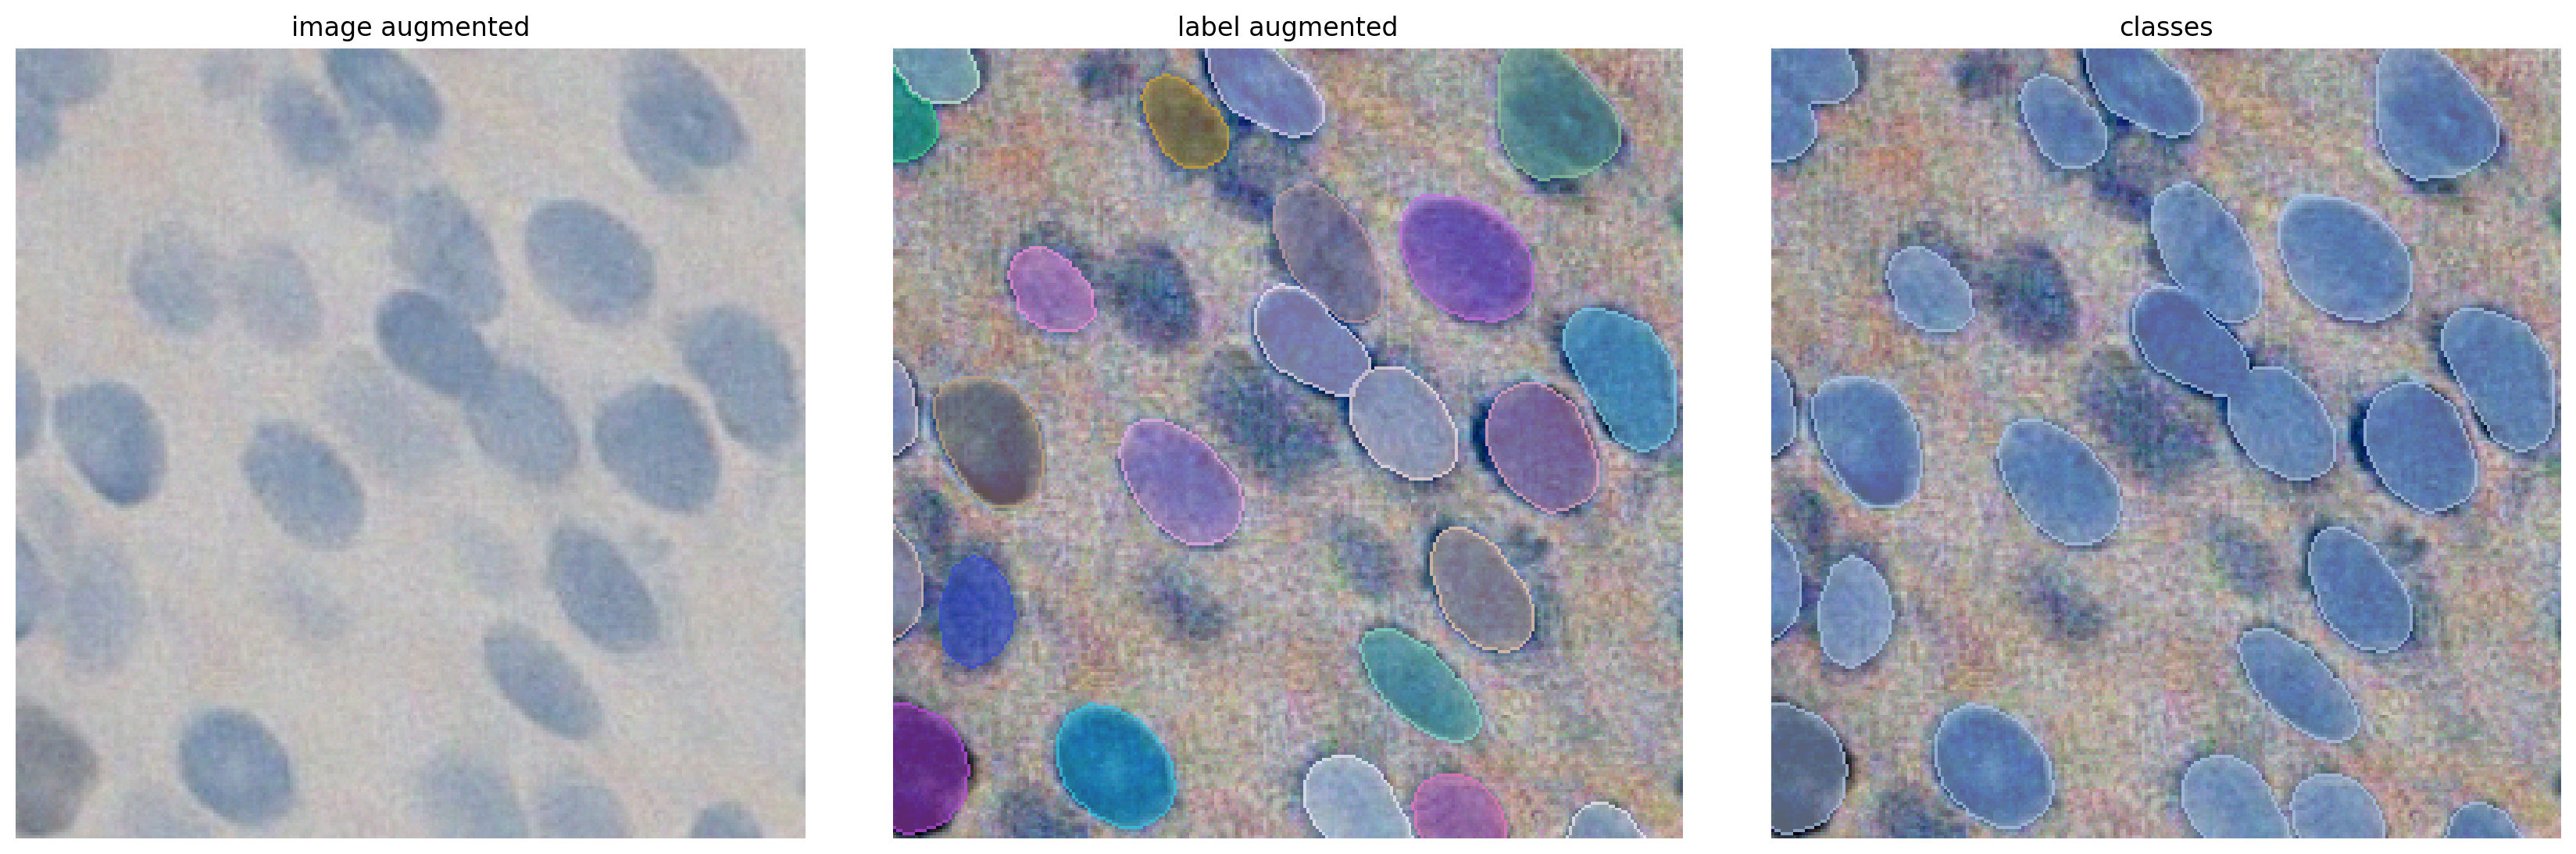

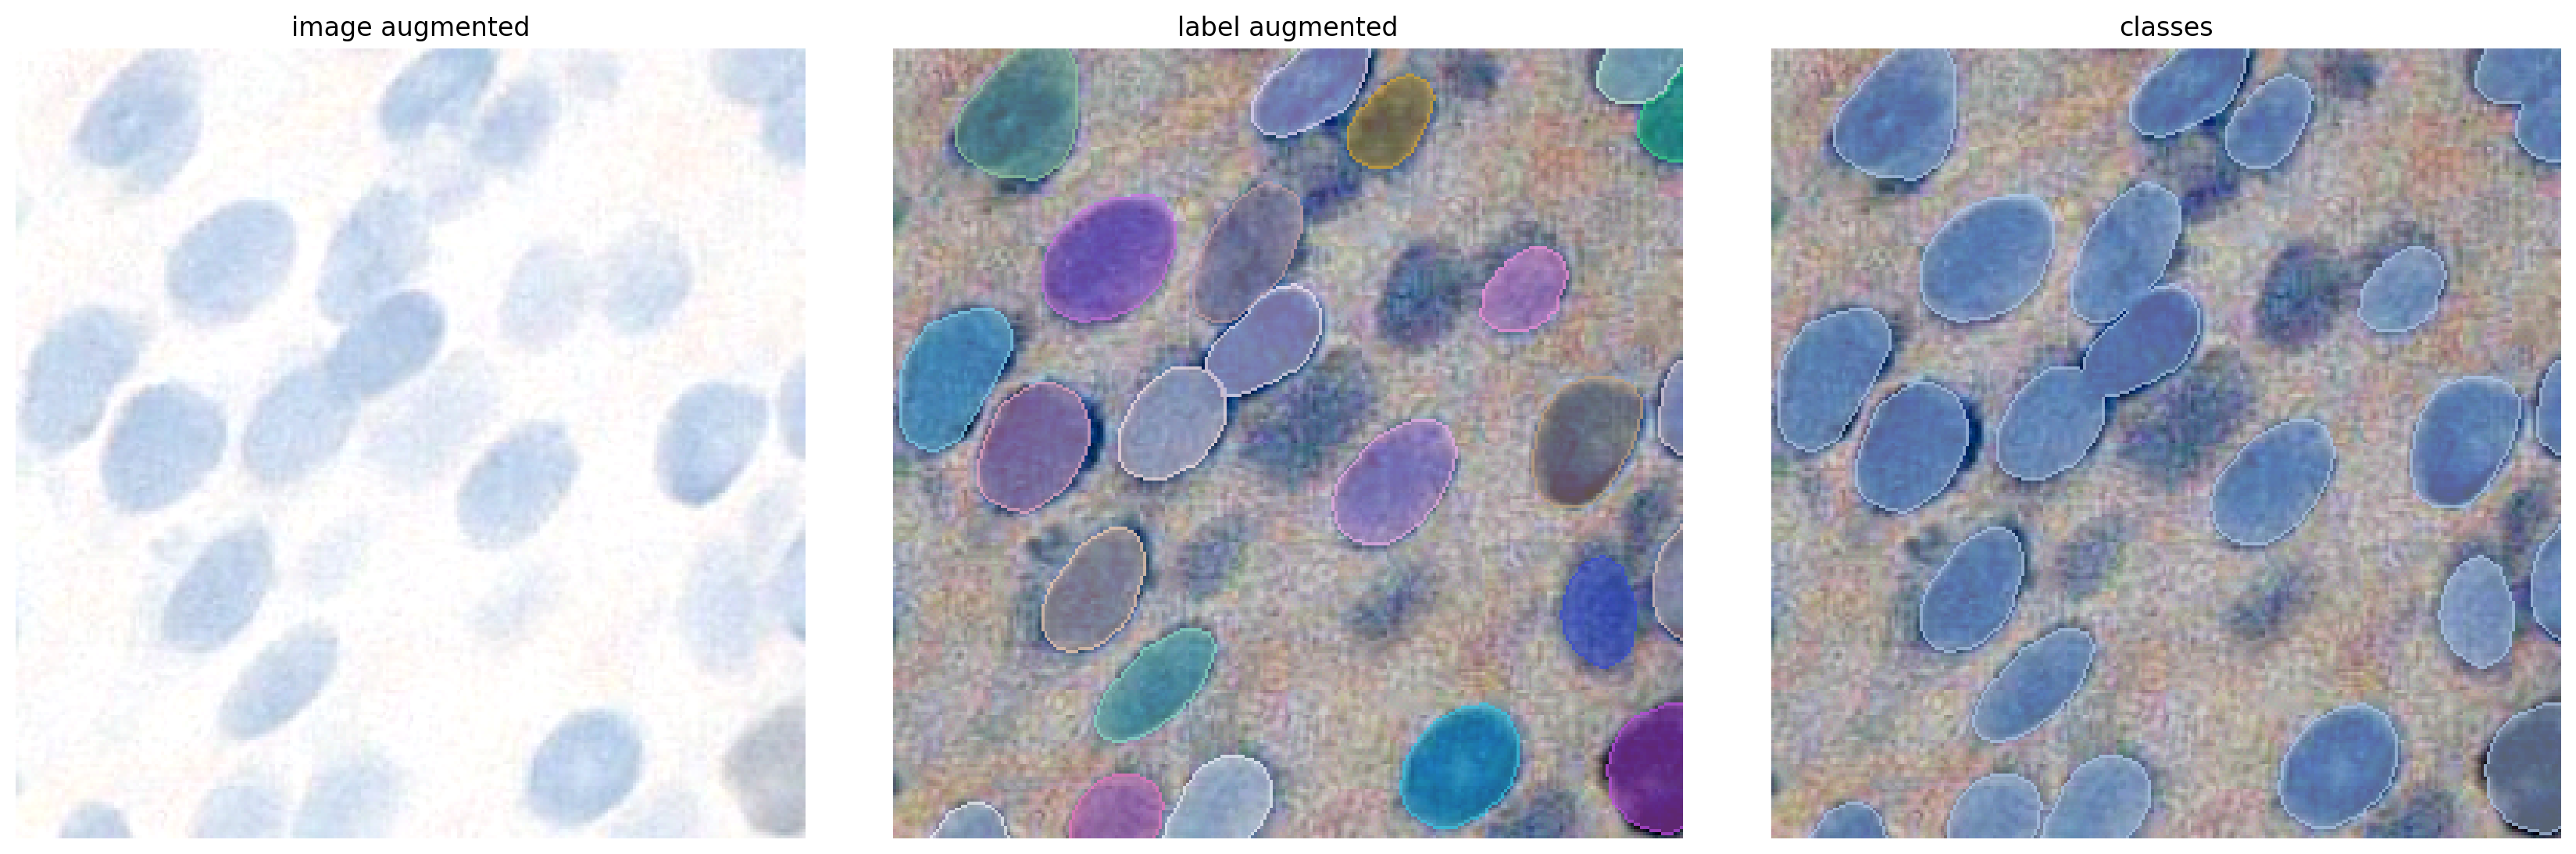

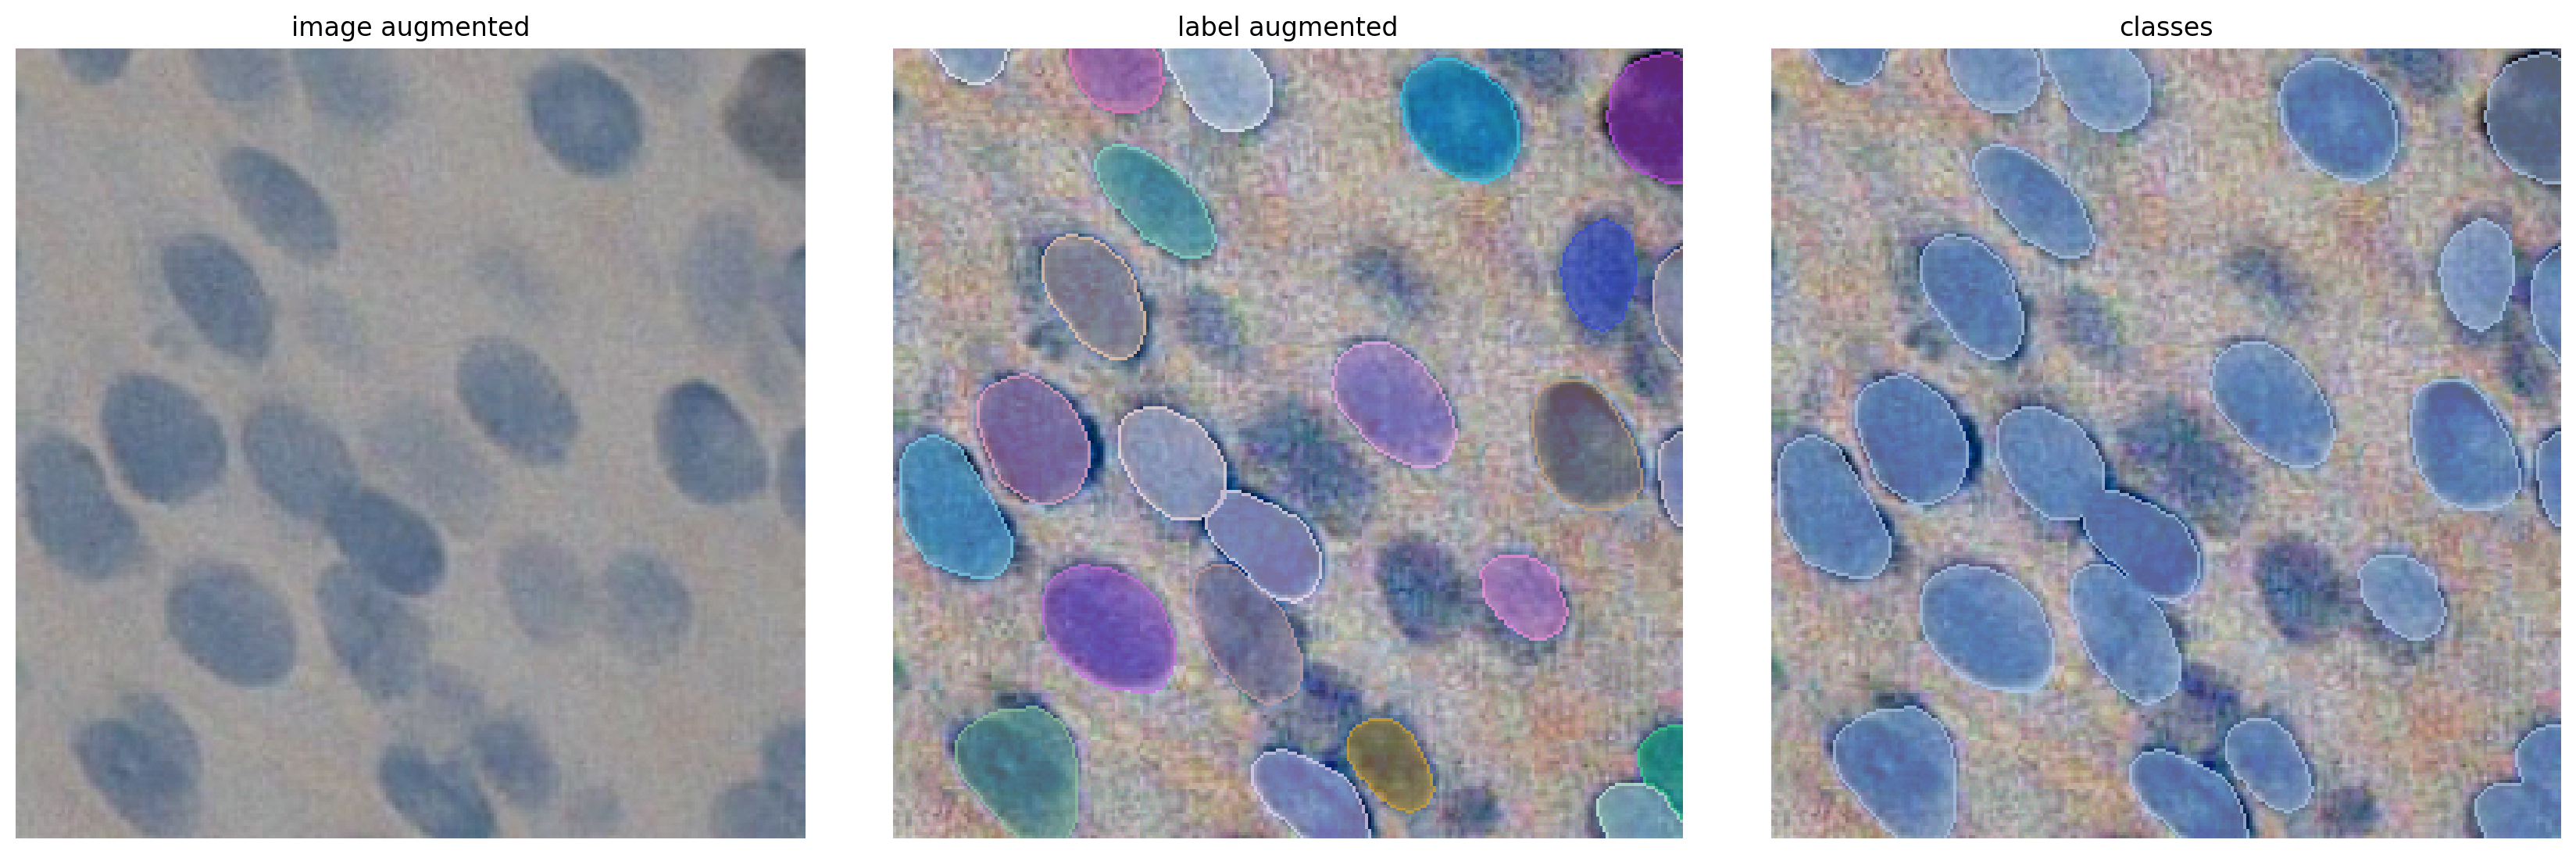

In [13]:
# plot some augmented examples
img, lbl, cls = X_trn[5], Y_trn[5], C_trn[5]
plot_img_label(img,lbl,cls, n_classes=n_classes)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)
None;

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=200) # 200 epochs seem to be enough for synthetic demo dataset

Epoch 1/200
Cause: Unable to locate the source code of <function _gcd_import at 0x00000252CD6D1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x00000252CD6D1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate 

Epoch 11/200
100/100 [==============================] - 20s 199ms/step - loss: 1.2006 - prob_loss: 0.1854 - dist_loss: 3.7755 - prob_class_loss: 0.2601 - prob_kld: 0.0582 - dist_relevant_mae: 3.7745 - dist_relevant_mse: 33.7383 - dist_dist_iou_metric: 0.6127 - val_loss: 1.2263 - val_prob_loss: 0.1990 - val_dist_loss: 3.7951 - val_prob_class_loss: 0.2683 - val_prob_kld: 0.0632 - val_dist_relevant_mae: 3.7942 - val_dist_relevant_mse: 40.0203 - val_dist_dist_iou_metric: 0.6168 - lr: 3.0000e-04
Epoch 12/200
100/100 [==============================] - 20s 203ms/step - loss: 1.1466 - prob_loss: 0.1925 - dist_loss: 3.4545 - prob_class_loss: 0.2631 - prob_kld: 0.0580 - dist_relevant_mae: 3.4536 - dist_relevant_mse: 28.4553 - dist_dist_iou_metric: 0.6347 - val_loss: 1.2227 - val_prob_loss: 0.1934 - val_dist_loss: 3.8349 - val_prob_class_loss: 0.2623 - val_prob_kld: 0.0576 - val_dist_relevant_mae: 3.8338 - val_dist_relevant_mse: 36.2072 - val_dist_dist_iou_metric: 0.6411 - lr: 3.0000e-04
Epoch 13

100/100 [==============================] - 20s 201ms/step - loss: 0.9246 - prob_loss: 0.1764 - dist_loss: 2.6394 - prob_class_loss: 0.2203 - prob_kld: 0.0454 - dist_relevant_mae: 2.6384 - dist_relevant_mse: 19.1646 - dist_dist_iou_metric: 0.7214 - val_loss: 0.9538 - val_prob_loss: 0.1824 - val_dist_loss: 2.7379 - val_prob_class_loss: 0.2238 - val_prob_kld: 0.0466 - val_dist_relevant_mae: 2.7369 - val_dist_relevant_mse: 25.5241 - val_dist_dist_iou_metric: 0.7246 - lr: 3.0000e-04
Epoch 34/200
100/100 [==============================] - 20s 198ms/step - loss: 0.9315 - prob_loss: 0.1712 - dist_loss: 2.7405 - prob_class_loss: 0.2122 - prob_kld: 0.0438 - dist_relevant_mae: 2.7395 - dist_relevant_mse: 20.6734 - dist_dist_iou_metric: 0.7141 - val_loss: 0.9591 - val_prob_loss: 0.1824 - val_dist_loss: 2.7783 - val_prob_class_loss: 0.2210 - val_prob_kld: 0.0466 - val_dist_relevant_mae: 2.7773 - val_dist_relevant_mse: 24.3444 - val_dist_dist_iou_metric: 0.7141 - lr: 3.0000e-04
Epoch 35/200
100/100 

100/100 [==============================] - 20s 202ms/step - loss: 0.8368 - prob_loss: 0.1696 - dist_loss: 2.3627 - prob_class_loss: 0.1947 - prob_kld: 0.0407 - dist_relevant_mae: 2.3617 - dist_relevant_mse: 16.8280 - dist_dist_iou_metric: 0.7525 - val_loss: 0.8718 - val_prob_loss: 0.1794 - val_dist_loss: 2.4257 - val_prob_class_loss: 0.2073 - val_prob_kld: 0.0436 - val_dist_relevant_mae: 2.4248 - val_dist_relevant_mse: 20.8267 - val_dist_dist_iou_metric: 0.7543 - lr: 3.0000e-04
Epoch 56/200
100/100 [==============================] - 20s 202ms/step - loss: 0.8312 - prob_loss: 0.1690 - dist_loss: 2.3061 - prob_class_loss: 0.2010 - prob_kld: 0.0396 - dist_relevant_mae: 2.3052 - dist_relevant_mse: 15.6200 - dist_dist_iou_metric: 0.7558 - val_loss: 0.8913 - val_prob_loss: 0.1845 - val_dist_loss: 2.4526 - val_prob_class_loss: 0.2163 - val_prob_kld: 0.0486 - val_dist_relevant_mae: 2.4517 - val_dist_relevant_mse: 21.1095 - val_dist_dist_iou_metric: 0.7562 - lr: 3.0000e-04
Epoch 57/200
100/100 

100/100 [==============================] - 20s 199ms/step - loss: 0.8095 - prob_loss: 0.1681 - dist_loss: 2.2297 - prob_class_loss: 0.1954 - prob_kld: 0.0384 - dist_relevant_mae: 2.2288 - dist_relevant_mse: 15.0512 - dist_dist_iou_metric: 0.7647 - val_loss: 0.8515 - val_prob_loss: 0.1773 - val_dist_loss: 2.3792 - val_prob_class_loss: 0.1984 - val_prob_kld: 0.0415 - val_dist_relevant_mae: 2.3783 - val_dist_relevant_mse: 19.2790 - val_dist_dist_iou_metric: 0.7650 - lr: 3.0000e-04
Epoch 78/200
100/100 [==============================] - 20s 198ms/step - loss: 0.7750 - prob_loss: 0.1650 - dist_loss: 2.1277 - prob_class_loss: 0.1845 - prob_kld: 0.0367 - dist_relevant_mae: 2.1268 - dist_relevant_mse: 13.5651 - dist_dist_iou_metric: 0.7717 - val_loss: 0.8429 - val_prob_loss: 0.1783 - val_dist_loss: 2.2762 - val_prob_class_loss: 0.2094 - val_prob_kld: 0.0424 - val_dist_relevant_mae: 2.2754 - val_dist_relevant_mse: 19.2022 - val_dist_dist_iou_metric: 0.7697 - lr: 3.0000e-04
Epoch 79/200
100/100 

100/100 [==============================] - 20s 196ms/step - loss: 0.7439 - prob_loss: 0.1607 - dist_loss: 2.0311 - prob_class_loss: 0.1770 - prob_kld: 0.0354 - dist_relevant_mae: 2.0303 - dist_relevant_mse: 12.9771 - dist_dist_iou_metric: 0.7842 - val_loss: 0.8066 - val_prob_loss: 0.1757 - val_dist_loss: 2.1955 - val_prob_class_loss: 0.1918 - val_prob_kld: 0.0399 - val_dist_relevant_mae: 2.1946 - val_dist_relevant_mse: 17.0545 - val_dist_dist_iou_metric: 0.7756 - lr: 3.0000e-04
Epoch 100/200
100/100 [==============================] - 20s 200ms/step - loss: 0.7651 - prob_loss: 0.1659 - dist_loss: 2.0868 - prob_class_loss: 0.1818 - prob_kld: 0.0361 - dist_relevant_mae: 2.0860 - dist_relevant_mse: 13.2053 - dist_dist_iou_metric: 0.7804 - val_loss: 0.8274 - val_prob_loss: 0.1810 - val_dist_loss: 2.2451 - val_prob_class_loss: 0.1973 - val_prob_kld: 0.0452 - val_dist_relevant_mae: 2.2442 - val_dist_relevant_mse: 17.2714 - val_dist_dist_iou_metric: 0.7698 - lr: 3.0000e-04
Epoch 101/200
100/10

100/100 [==============================] - 20s 201ms/step - loss: 0.7352 - prob_loss: 0.1650 - dist_loss: 1.9772 - prob_class_loss: 0.1747 - prob_kld: 0.0343 - dist_relevant_mae: 1.9764 - dist_relevant_mse: 12.1528 - dist_dist_iou_metric: 0.7914 - val_loss: 0.8013 - val_prob_loss: 0.1767 - val_dist_loss: 2.1620 - val_prob_class_loss: 0.1922 - val_prob_kld: 0.0408 - val_dist_relevant_mae: 2.1612 - val_dist_relevant_mse: 17.5021 - val_dist_dist_iou_metric: 0.7793 - lr: 3.0000e-04
Epoch 122/200
100/100 [==============================] - 20s 199ms/step - loss: 0.7359 - prob_loss: 0.1647 - dist_loss: 1.9797 - prob_class_loss: 0.1753 - prob_kld: 0.0342 - dist_relevant_mae: 1.9789 - dist_relevant_mse: 12.0948 - dist_dist_iou_metric: 0.7897 - val_loss: 0.8390 - val_prob_loss: 0.1756 - val_dist_loss: 2.3252 - val_prob_class_loss: 0.1984 - val_prob_kld: 0.0397 - val_dist_relevant_mae: 2.3242 - val_dist_relevant_mse: 18.2365 - val_dist_dist_iou_metric: 0.7708 - lr: 3.0000e-04
Epoch 123/200
100/10

100/100 [==============================] - 20s 199ms/step - loss: 0.7114 - prob_loss: 0.1629 - dist_loss: 1.9007 - prob_class_loss: 0.1683 - prob_kld: 0.0321 - dist_relevant_mae: 1.8999 - dist_relevant_mse: 11.1456 - dist_dist_iou_metric: 0.7957 - val_loss: 0.7943 - val_prob_loss: 0.1755 - val_dist_loss: 2.1301 - val_prob_class_loss: 0.1927 - val_prob_kld: 0.0397 - val_dist_relevant_mae: 2.1293 - val_dist_relevant_mse: 16.9409 - val_dist_dist_iou_metric: 0.7859 - lr: 3.0000e-04
Epoch 144/200
100/100 [==============================] - 20s 198ms/step - loss: 0.6986 - prob_loss: 0.1607 - dist_loss: 1.8488 - prob_class_loss: 0.1681 - prob_kld: 0.0318 - dist_relevant_mae: 1.8480 - dist_relevant_mse: 10.4581 - dist_dist_iou_metric: 0.8006 - val_loss: 0.8006 - val_prob_loss: 0.1756 - val_dist_loss: 2.1656 - val_prob_class_loss: 0.1919 - val_prob_kld: 0.0398 - val_dist_relevant_mae: 2.1647 - val_dist_relevant_mse: 17.5978 - val_dist_dist_iou_metric: 0.7784 - lr: 3.0000e-04
Epoch 145/200
100/10

100/100 [==============================] - 20s 202ms/step - loss: 0.7116 - prob_loss: 0.1643 - dist_loss: 1.9072 - prob_class_loss: 0.1659 - prob_kld: 0.0320 - dist_relevant_mae: 1.9064 - dist_relevant_mse: 11.6041 - dist_dist_iou_metric: 0.7989 - val_loss: 0.7859 - val_prob_loss: 0.1745 - val_dist_loss: 2.1075 - val_prob_class_loss: 0.1899 - val_prob_kld: 0.0386 - val_dist_relevant_mae: 2.1067 - val_dist_relevant_mse: 16.1027 - val_dist_dist_iou_metric: 0.7900 - lr: 3.0000e-04
Epoch 166/200
100/100 [==============================] - 20s 198ms/step - loss: 0.6966 - prob_loss: 0.1584 - dist_loss: 1.8811 - prob_class_loss: 0.1620 - prob_kld: 0.0307 - dist_relevant_mae: 1.8803 - dist_relevant_mse: 11.0669 - dist_dist_iou_metric: 0.7998 - val_loss: 0.8042 - val_prob_loss: 0.1746 - val_dist_loss: 2.1853 - val_prob_class_loss: 0.1925 - val_prob_kld: 0.0387 - val_dist_relevant_mae: 2.1845 - val_dist_relevant_mse: 17.2337 - val_dist_dist_iou_metric: 0.7844 - lr: 3.0000e-04
Epoch 167/200
100/10

100/100 [==============================] - 20s 197ms/step - loss: 0.6673 - prob_loss: 0.1563 - dist_loss: 1.7713 - prob_class_loss: 0.1568 - prob_kld: 0.0288 - dist_relevant_mae: 1.7704 - dist_relevant_mse: 9.5358 - dist_dist_iou_metric: 0.8095 - val_loss: 0.7972 - val_prob_loss: 0.1748 - val_dist_loss: 2.1261 - val_prob_class_loss: 0.1972 - val_prob_kld: 0.0389 - val_dist_relevant_mae: 2.1252 - val_dist_relevant_mse: 16.5982 - val_dist_dist_iou_metric: 0.7885 - lr: 3.0000e-04
Epoch 188/200
100/100 [==============================] - 20s 200ms/step - loss: 0.6784 - prob_loss: 0.1597 - dist_loss: 1.8005 - prob_class_loss: 0.1586 - prob_kld: 0.0293 - dist_relevant_mae: 1.7997 - dist_relevant_mse: 10.0289 - dist_dist_iou_metric: 0.8080 - val_loss: 0.7732 - val_prob_loss: 0.1751 - val_dist_loss: 2.0396 - val_prob_class_loss: 0.1902 - val_prob_kld: 0.0392 - val_dist_relevant_mae: 2.0388 - val_dist_relevant_mse: 15.8704 - val_dist_dist_iou_metric: 0.7927 - lr: 3.0000e-04
Epoch 189/200
100/100